#Stock Market Prediction LSTM

In [1]:
!pip install transformers
!pip install pynytimes
!pip install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.5 MB/s eta 0:00:00


In [2]:
# Importing the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pynytimes import NYTAPI
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def get_news(year, month, day):
    """
    get top 10 most relevent finance news headings on each day from NY times
    """
    # API call to New York Timess with the key below
    nyt = NYTAPI("GM4G4Ayt0m1ME6g3ulsBfYRKDx9bRj80", parse_dates=True)
    
    list = []
    articles = nyt.article_search(
            results = 10,
            dates = {
                "begin": datetime.datetime(year, month, day),
                "end": datetime.datetime(year, month, day)
            },
            options = {
                "sort": "relevance",
                "news_desk": [
                    "Business", "Business Day", "Entrepreneurs", "Financial", "Technology"
                ],
                "section_name" : [
                    "Business", "Business Day", "Technology"
                ]
            }
        )
    for i in range(len(articles)):
        list.append(articles[i]['abstract'].replace(',', ""))
    return list

df = pd.DataFrame()

In [ ]:
def generate_news_file():
    """
    store news headings everyday of in csv
    """
    start = '2021-01-01'
    end = '2022-01-01'
    mydates = pd.date_range(start, end)
    dates = []
    for i in range(len(mydates)):
        dates.append(mydates[i].strftime("%Y-%m-%d"))
    matrix = np.zeros((len(dates) + 1, 11), dtype=object)  
    matrix[0, 0] = "Date"

    for i in range(10):
        matrix[0, i + 1] = f"News {i + 1}"
    for i in range(len(dates)):
        matrix[i + 1, 0] = dates[i]
        y, m, d = dates[i].split("-")
        news_list = get_news(int(y), int(m), int(d))
        for j in range(len(news_list)):
            matrix[i + 1, j + 1] = news_list[j]
    df = pd.DataFrame(matrix)
    df.to_csv("news.csv", index = False)


generate_news_file()

##Downloading the Stock data from Yahoo finance

In [9]:
def download_stock_data(ticker, start, end):
    """
    download stock price data from Yahoo Finance
    """
    import yfinance as yf
    stock_data = yf.download(ticker, start, end)
    df = pd.DataFrame(stock_data)
    df.to_csv("news.csv")

In [10]:
# Downloading the stock data from yahoo finance 
download_stock_data("NDX", "2016-06-06", "2021-06-04")

[*********************100%***********************]  1 of 1 completed


##Merging the data and news together

In [4]:
news_df = pd.read_csv("/content/drive/MyDrive/Stock data/news.csv")
stock_df = pd.read_csv("/content/drive/MyDrive/Stock data/stock_price.csv")

for i in range(len(stock_df)):
    date = stock_df['Date'][i][:10]
    stock_df['Date'][i] = date

news_df = news_df[news_df['Date'].isin(stock_df['Date'].tolist())]

news_df.to_csv("news_data.csv", index=False)

<ipython-input-4-0cf38790f7fc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'][i] = date


##Calculating the finBERT score for sentiment analysis
finBERT_sentiment_score is a sentiment analysis tool that uses a pre-trained BERT model to predict the sentiment of a given piece of text. The model is trained on a large corpus of financial news and analyst reports, and it can be used to identify positive, negative, and neutral sentiment in financial text. The tool is available as a Python library, and it can be used to analyze text from a variety of sources, including news articles, social media posts, and financial reports.

Here are some examples of how finBERT_sentiment_score can be used:
- To identify positive and negative sentiment in financial news articles.
- To track the sentiment of a company's stock over time.
- To identify sentiment in social media posts about a particular financial topic.
- To analyze the sentiment of analyst reports.

finBERT_sentiment_score is a powerful tool that can be used to gain insights into the sentiment of financial text. It can be used by investors, traders, and analysts to make better decisions about their investments.

In [5]:
def FinBERT_sentiment_score(heading):
    """
    compute sentiment score using pretrained FinBERT on -1 to 1 scale. -1 being negative and 1 being positive
    """
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    from transformers import pipeline
    tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
    finbert = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)
    result = nlp(heading)
    if result[0]['label'] == "positive":
        return result[0]['score']
    elif result[0]['label'] == "neutral":
        return 0
    else:
        return (0 - result[0]['score'])

##Calculating the VADER score for sentiment analysis
VADER_sentiment_score is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains. It is a compound score computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

Here are some examples of how VADER_sentiment_score works:
- "I love this movie!" would have a VADER_sentiment_score of +1.
- "I hated this movie!" would have a VADER_sentiment_score of -1.
- "The movie was okay." would have a VADER_sentiment_score of 0.

VADER_sentiment_score can be used to measure the sentiment of text in a variety of applications, such as social media monitoring, customer sentiment analysis, and product reviews.

In [6]:
def VADER_sentiment_score(heading):
    """
    compute sentiment score using pretrained VADER on -1 to 1 scale. -1 being negative and 1 being positive
    """
    import nltk
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    nltk.download('vader_lexicon')
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    result = analyzer.polarity_scores(heading)
    if result['pos'] == max(result['neg'], result['neu'], result['pos']):
        return result['pos']
    if result['neg'] == max(result['neg'], result['neu'], result['pos']):
        return (0 - result['neg'])
    else:
        return 0

In [7]:
news_df = pd.read_csv("news_data.csv")

In [8]:
BERT_sentiment = []

In [17]:
# Calculating finBERT score for each day and Store in BERT_sentiment
for i in range(len(news_df)):
    news_list = news_df.iloc[i, 1:].tolist()
    news_list = [str(i).strip() for i in news_list if str(i).strip() != '' and str(i).strip().lower() != 'nan' and str(i).strip() != '0']
    score_BERT = FinBERT_sentiment_score(news_list)
    BERT_sentiment.append(score_BERT)


In [18]:
 news_df['FinBERT score'] = BERT_sentiment

In [19]:
news_df.to_csv("sentiment.csv")

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

##Training the LSTM model

In [10]:
# hyperparameters
split = (0.85);
sequence_length = 30;
epochs = 30
learning_rate = 0.02

In [11]:
# loading stock price data
stock_data = pd.read_csv("/content/drive/MyDrive/Stock data/stock_price.csv")
column = ['Close']

In [12]:
len_stock_data = stock_data.shape[0]

In [13]:
# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]

In [14]:
# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

In [15]:
# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)

In [16]:
shape = (X_train.shape[1], 1)
print(shape)

(30, 1)


In [17]:
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )
    model.compile(
        loss = tf.keras.losses.mean_squared_error,
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )


    model.fit(
        X_train, y_train,
        epochs = epochs
    )
    model.save("LSTM_model.h5")
    return model

In [18]:
# inverting normaliztion
y_test = scaler.inverse_transform(y_test)

In [19]:
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions

In [20]:
# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)

In [21]:
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
    return (total_mae / n), (total_mape / n), (total_acc / n),predictions.tolist()

In [22]:
mae, mape, acc, preds = run_model(1)

Epoch 1/30
13/13 [==============================] - 10s 48ms/step - loss: 0.2383
Epoch 2/30
13/13 [==============================] - 1s 44ms/step - loss: 0.0152
Epoch 3/30
13/13 [==============================] - 1s 49ms/step - loss: 0.0075
Epoch 4/30
13/13 [==============================] - 1s 45ms/step - loss: 0.0070
Epoch 5/30
13/13 [==============================] - 1s 45ms/step - loss: 0.0056
Epoch 6/30
13/13 [==============================] - 1s 50ms/step - loss: 0.0058
Epoch 7/30
13/13 [==============================] - 1s 47ms/step - loss: 0.0063
Epoch 8/30
13/13 [==============================] - 1s 48ms/step - loss: 0.0060
Epoch 9/30
13/13 [==============================] - 1s 48ms/step - loss: 0.0050
Epoch 10/30
13/13 [==============================] - 1s 45ms/step - loss: 0.0047
Epoch 11/30
13/13 [==============================] - 1s 48ms/step - loss: 0.0045
Epoch 12/30
13/13 [==============================] - 1s 46ms/step - loss: 0.0044
Epoch 13/30
13/13 [=================

In [23]:
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

Mean Absolute Error = 243.7414232336958
Mean Absolute Percentage Error = 0.019473845783840475%
Accuracy = 0.9805261542161595


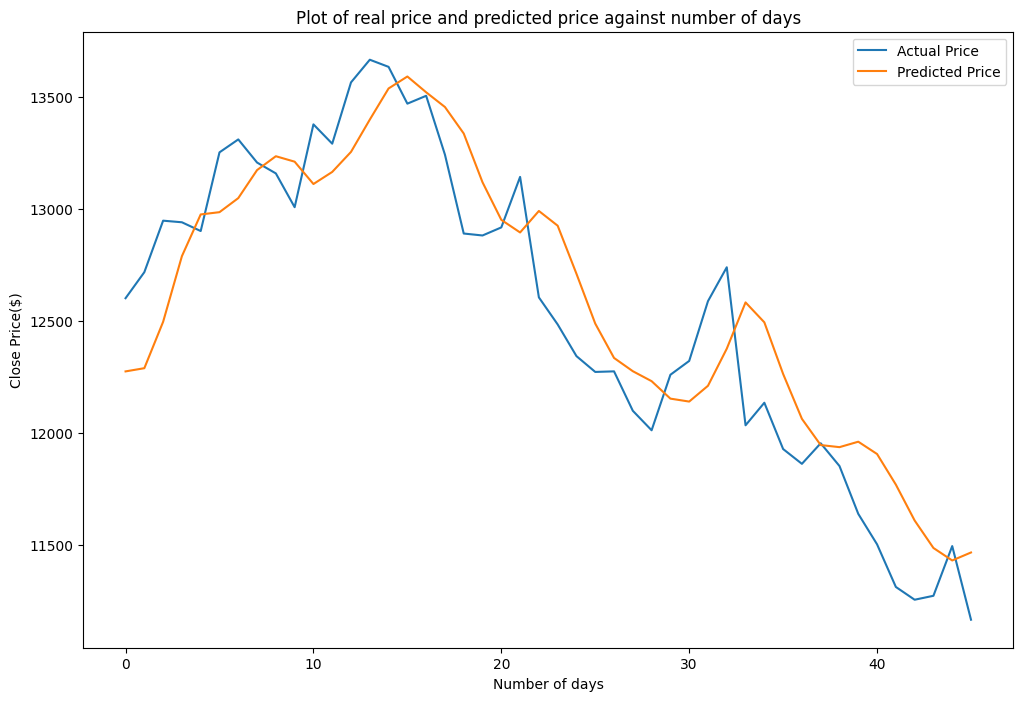

In [24]:
real = plt.plot(y_test, label='Actual Price')
pred = plt.plot(preds, label='Predicted Price')

plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days')
plt.xlabel('Number of days')
plt.ylabel('Close Price($)')

plt.legend(['Actual Price', 'Predicted Price'])
plt.show()    

#Stock Market Prediction LSTM + Sentiment Analysis

In [41]:
split = (0.85);
sequence_length = 30;
epochs = 30
learning_rate = 0.02

In [42]:
# loading stock price and news data
stock_data = pd.read_csv("/content/drive/MyDrive/Stock data/stock_price.csv")
news_data = pd.read_csv("sentiment.csv")
stock_column = ['Close']
news_column = ['FinBERT score']

In [43]:
len_stock_data = stock_data.shape[0]

In [44]:
# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(stock_column).values[:train_examples]
train_sentiment = news_data.get(news_column).values[:train_examples]
test = stock_data.get(stock_column).values[train_examples:]
test_sentiment = news_data.get(news_column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]
len_train_sentiment = train_sentiment.shape[0]
len_test_sentiment = test_sentiment.shape[0]

In [45]:
# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

In [46]:
# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
len_X_train = len(X_train)
y_train = np.array(train[sequence_length:]).astype(float)

In [47]:
# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
len_X_test = len(X_test)
y_test = np.array(test[sequence_length:]).astype(float)

In [48]:
# adding news sentiment to train and test
for i in range(len_X_train):
    X_train[i] = X_train[i].tolist()
    X_train[i].append(train_sentiment[sequence_length + i].tolist())
X_train = np.array(X_train).astype(float)

for i in range(len_X_test):
    X_test[i] = X_test[i].tolist()
    X_test[i].append(test_sentiment[sequence_length + i].tolist())
X_test = np.array(X_test).astype(float)

In [49]:
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 70, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 10, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss = tf.keras.losses.mean_squared_error,
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    model.fit(
        X_train, y_train,
        epochs = epochs
    )

    model.save('LSTM_sentiment.h5')
    
    return model

In [50]:
# inverting normaliztion
y_test = scaler.inverse_transform(y_test)

In [51]:
# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions

In [52]:
# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)

In [53]:
# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
    return (total_mae / n), (total_mape / n), (total_acc / n),predictions.tolist()

In [54]:
mae, mape, acc,preds = run_model(1)

Epoch 1/30
13/13 [==============================] - 7s 49ms/step - loss: 0.1144
Epoch 2/30
13/13 [==============================] - 1s 49ms/step - loss: 0.0154
Epoch 3/30
13/13 [==============================] - 1s 48ms/step - loss: 0.0063
Epoch 4/30
13/13 [==============================] - 1s 47ms/step - loss: 0.0051
Epoch 5/30
13/13 [==============================] - 1s 49ms/step - loss: 0.0041
Epoch 6/30
13/13 [==============================] - 1s 47ms/step - loss: 0.0038
Epoch 7/30
13/13 [==============================] - 1s 81ms/step - loss: 0.0037
Epoch 8/30
13/13 [==============================] - 1s 86ms/step - loss: 0.0040
Epoch 9/30
13/13 [==============================] - 1s 82ms/step - loss: 0.0035
Epoch 10/30
13/13 [==============================] - 1s 87ms/step - loss: 0.0028
Epoch 11/30
13/13 [==============================] - 1s 81ms/step - loss: 0.0028
Epoch 12/30
13/13 [==============================] - 1s 68ms/step - loss: 0.0028
Epoch 13/30
13/13 [==================

In [55]:
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

Mean Absolute Error = 231.32958984375017
Mean Absolute Percentage Error = 0.018423923083492357%
Accuracy = 0.9815760769165076


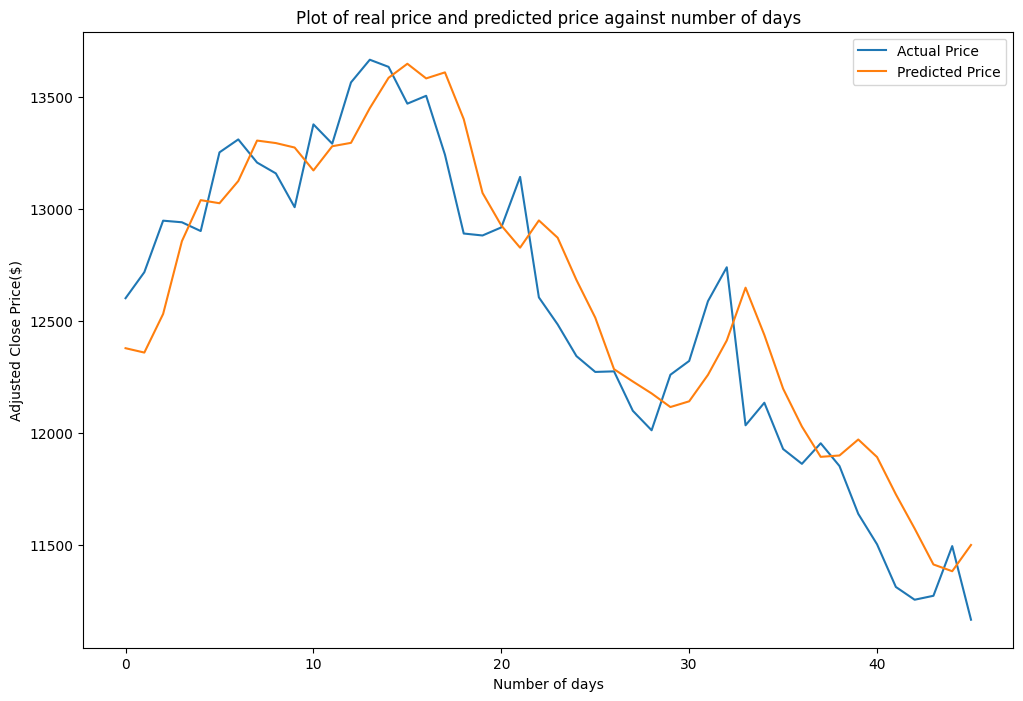

In [56]:
real = plt.plot(y_test, label='Actual Price')
pred = plt.plot(preds, label='Predicted Price')

plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days')
plt.xlabel('Number of days')
plt.ylabel('Adjusted Close Price($)')

plt.legend(['Actual Price', 'Predicted Price'])
plt.show()